# Импорт библиотек

In [1]:
import os
import random
import requests
import gdown
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Параметры

In [2]:
num_epochs = 10
img_height = 300
img_width = 224
random_seed = 42
num_classes = 2
batch_size = 32

In [3]:
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
os.environ["PYTHONHASHSEED"] = str(random_seed)
print(f"Текущий seed: {random_seed}")

Текущий seed: 42


# Загрузка данных

In [4]:
OUTPUT_FOLDER = "/content"
gdown.download_folder('https://drive.google.com/drive/folders/1hXAjwpBj6shfWd1taWMFpSqelFCzi6KJ', output=OUTPUT_FOLDER)

Retrieving folder contents


Processing file 1585FWwha2MJGWyRvKmLRxmqblvmsjSq3 georges.csv
Processing file 1XjTxMwfcSAZJIlcw2cZzVy1UzUCzIoID non_georges.csv
Processing file 1o54Y1wmjgY5K61ucZ4Q2FZbz-IWQvFJO project_boilerplate.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1585FWwha2MJGWyRvKmLRxmqblvmsjSq3
To: /content/georges.csv
100%|██████████| 196k/196k [00:00<00:00, 5.15MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XjTxMwfcSAZJIlcw2cZzVy1UzUCzIoID
To: /content/non_georges.csv
100%|██████████| 246k/246k [00:00<00:00, 4.55MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o54Y1wmjgY5K61ucZ4Q2FZbz-IWQvFJO
To: /content/project_boilerplate.zip
100%|██████████| 32.3k/32.3k [00:00<00:00, 25.4MB/s]
Download completed


['/content/georges.csv',
 '/content/non_georges.csv',
 '/content/project_boilerplate.zip']

In [4]:
georges_file = "georges.csv"
non_georges_file = "non_georges.csv"

georges_folder = "georges_images"
non_georges_folder = "non_georges_images"

In [5]:
os.makedirs(georges_folder, exist_ok=True)
os.makedirs(non_georges_folder, exist_ok=True)

In [7]:
def download_image(url, filename):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        return True
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при скачивании {url}: {e}")
        return False


def download_images_from_csv(csv_file, output_folder):
    df = pd.read_csv(csv_file, header=None)
    links = df[0].tolist()

    for i, link in enumerate(links):
        filename = os.path.join(output_folder, f"image_{i}.jpg")
        if not os.path.exists(filename):
            if not download_image(link, filename):
                print(f"Не удалось скачать изображение {link}")

In [8]:
print("Загрузка изображений с Георгием...")
download_images_from_csv(georges_file, georges_folder)

Загрузка изображений с Георгием...


In [9]:
print("Загрузка изображений без Георгия...")
download_images_from_csv(non_georges_file, non_georges_folder)

Загрузка изображений без Георгия...


# Работа с данными

## Исследование

In [ ]:
# Визуализация 5 изображений каждого класса
def visualize_images(georges_folder, non_georges_folder):
    georges_images = os.listdir(georges_folder)[:5]
    non_georges_images = os.listdir(non_georges_folder)[:5]

    plt.figure(figsize=(10, 5))

    for i, img_file in enumerate(georges_images):
        img_path = os.path.join(georges_folder, img_file)
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Георгий")

    for i, img_file in enumerate(non_georges_images):
        img_path = os.path.join(non_georges_folder, img_file)
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 6)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Не Георгий")

    plt.tight_layout()
    plt.show()

visualize_images(georges_folder, non_georges_folder)

In [7]:
num_georges = len(os.listdir(georges_folder))
num_non_georges = len(os.listdir(non_georges_folder))

print(f"Количество изображений с Георгием: {num_georges}")
print(f"Количество изображений без Георгия: {num_non_georges}")

Количество изображений с Георгием: 2681
Количество изображений без Георгия: 3366


## Преобразование данных

In [8]:
def load_and_preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])

    return img, label

def create_dataset(georges_folder, non_georges_folder, train=True):
    image_paths = []
    labels = []

    for img in os.listdir(georges_folder):
        image_paths.append(os.path.join(georges_folder, img))
        labels.append(1)  # Георгий Победоносец

    for img in os.listdir(non_georges_folder):
        image_paths.append(os.path.join(non_georges_folder, img))
        labels.append(0)  # Не Георгий

    image_paths = np.array(image_paths)
    labels = np.array(labels)

    return image_paths, labels

In [9]:
all_image_paths, all_labels = create_dataset(georges_folder, non_georges_folder)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=random_seed, stratify=all_labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.5, random_state=random_seed, stratify=test_labels
)

In [10]:
def augment_data(image, label):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.clip_by_value(image, 0.0, 255.0)

    image = image / 255.0

    return image, label

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda image, label: (image / 255.0, label))
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda image, label: (image / 255.0, label))
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Обучение

## Подготовка модели

In [12]:
def create_model(num_classes=2):
    base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

    # Разморозка нескольких слоев
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    inputs = Input(shape=(img_height, img_width, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = create_model(num_classes=num_classes)

In [13]:
optimizer = Adam(learning_rate=0.001)
loss_fn = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

In [14]:
# Подсчет весов
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

## Обучение модели

In [15]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=num_epochs,
                    class_weight=class_weight_dict,
                    verbose=1)

Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - loss: 0.4584 - sparse_categorical_accuracy: 0.7745 - val_loss: 0.5291 - val_sparse_categorical_accuracy: 0.7752
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 104s 451ms/step - loss: 0.2797 - sparse_categorical_accuracy: 0.8850 - val_loss: 0.8046 - val_sparse_categorical_accuracy: 0.5570
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 69s 452ms/step - loss: 0.2007 - sparse_categorical_accuracy: 0.9212 - val_loss: 3.2809 - val_sparse_categorical_accuracy: 0.4545
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 84s 465ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.9326 - val_loss: 0.5543 - val_sparse_categorical_accuracy: 0.7802
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 466ms/step - loss: 0.1487 - sparse_categorical_accuracy: 0.9426 - val_loss: 1.0196 - val_sparse_categorical_accuracy: 0.5570
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 82s 464ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.9627 - val_loss: 0.6688 - val_sparse_categorical_accu

In [16]:
# Проверка модели
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - loss: 0.6860 - sparse_categorical_accuracy: 0.7553
Test Loss: 0.6450, Test Accuracy: 0.7702


# Метрики и графики

In [17]:
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

y_pred_positive_class = tf.nn.softmax(y_pred_probs)[:, 1]
roc_auc = roc_auc_score(test_labels, y_pred_positive_class)

19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 766ms/step


In [18]:
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.7702
Precision: 0.7022
Recall: 0.8358
F1 Score: 0.7632
ROC AUC: 0.8771


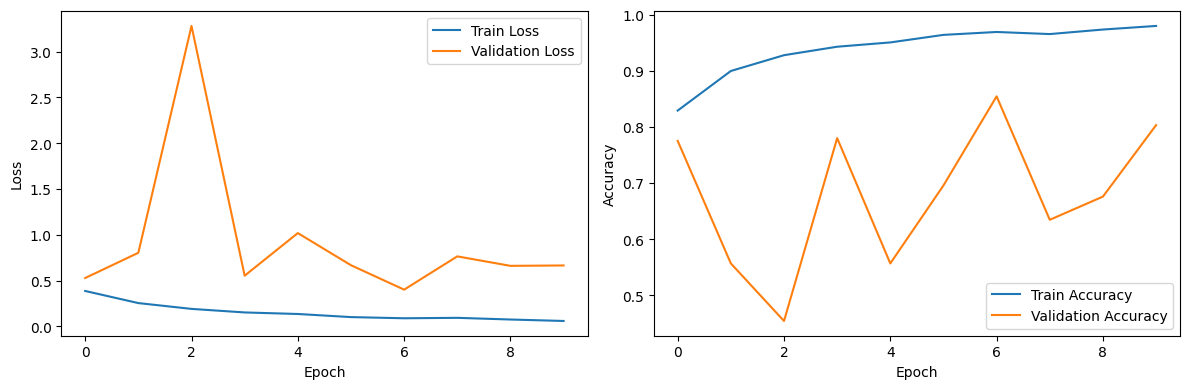

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

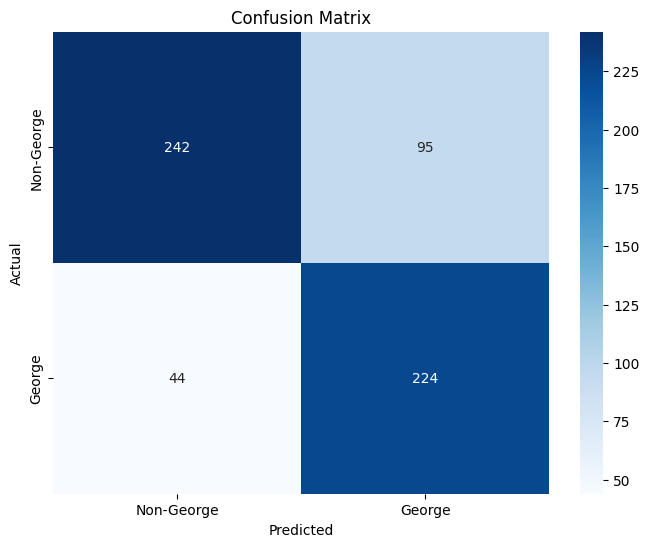

In [20]:
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-George", "George"],
            yticklabels=["Non-George", "George"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()